In [62]:
import pandas as pd
import numpy as np


## the other data set uses FIPS (the 'COUNTY' field here) as an int, so we need
## to as well.
# dtypes = {
#     'COUNTY': str
# }


## this data is from 
df = pd.read_csv("vaccinetracking/vacc_data/data_county_current.csv",
    parse_dates=['DATE'])

## take only county-level data.
## rename to make usage of column clear
df = df[df.GEOFLAG == 'County'].rename(columns={'COUNTY': 'FIPS'})

## these are irrelevant because we're using the date field
df = df.drop(['STATE', 'WEEK', 'YEAR'], axis=1)

df[df.FIPS == 36061]

,STATE_NAME,COUNTY_NAME,FIPS,GEOFLAG,DATE,CASE_TYPE,CASES,POPN
11016,NY,New York,36061,County,2022-02-25,Booster,5.885270e+05,1628706.0
11017,NY,New York,36061,County,2022-02-25,Booster Coverage,3.613464e+01,1628706.0
11018,NY,New York,36061,County,2022-02-25,Complete,1.365710e+06,1628706.0
11019,NY,New York,36061,County,2022-02-25,Complete Coverage,8.385246e+01,1628706.0
11020,NY,New York,36061,County,2022-02-25,Partial,1.755507e+06,1628706.0
11021,NY,New York,36061,County,2022-02-25,Partial Coverage,1.000000e+02,1628706.0


According to the [codebook](https://github.com/bansallab/vaccinetracking/tree/main/vacc_data#codebook), the columns with "Coverage" are pre-computed percentages.

"Partial/ Partial Coverage" is anybody with at least 1 shot, not people with *only* one shot.

So essentially the unvax percentage is `1 - df[df.CASE_TYPE == 'Partial Coverage' ]`

I should use raw counts when joining...

## Question 1a (MVP): Is there a correlation between vax rate and covid fatality rate?

## Question 1b (MVP): Is there a correlation between income and vaccination rate?


In [73]:
partial_coverage = df[df.CASE_TYPE == 'Partial Coverage']

unvaxed_by_fips = df.loc[df.CASE_TYPE == 'Partial Coverage', ['FIPS', 'CASES', 'POPN']]
#partial_coverage[['FIPS', 'CASES']]

unvaxed_by_fips[unvaxed_by_fips.FIPS == 36061]

unvaxed_by_fips['UNVAX_PERCENT'] = 100 - unvaxed_by_fips['CASES']

unvaxed_by_fips = unvaxed_by_fips.drop("CASES", axis=1)    



In [93]:
## time to get the covid fatality rate by FIPS.

#deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"

deaths_url = 'time_series_covid19_deaths_US.csv'


## they actually treat FIPS as an integer, so we do that =()
# death_dtypes = {
#     'FIPS': str

# }

deaths_df = pd.read_csv(deaths_url) # , dtype = death_dtypes)

## TODO: get the last column of the time series rather than '2/28/22' hardcoded.

cols = ['FIPS', 'Admin2', 'Province_State', '2/28/22']

deaths_cleaned = deaths_df.loc[:, cols].rename(columns={'2/28/22': 'DEATHS', 'Admin2': 'COUNTY', 
                                                        'Province_State': 'STATE' })

joined = deaths_cleaned.set_index('FIPS').join(unvaxed_by_fips.set_index('FIPS'), how='inner')

joined['DEATH_RATE'] = joined['DEATHS'] /  joined['POPN']

joined = joined[joined['DEATHS'] != 0]

joined


,COUNTY,STATE,DEATHS,POPN,UNVAX_PERCENT,DEATH_RATE
FIPS,,,,,,
1001.0,Autauga,Alabama,194,55869.0,45.153842,0.003472
1003.0,Baldwin,Alabama,640,223234.0,36.427695,0.002867
1005.0,Barbour,Alabama,93,24686.0,44.989063,0.003767
1007.0,Bibb,Alabama,99,22394.0,57.778869,0.004421
1009.0,Blount,Alabama,218,57826.0,62.065507,0.003770
...,...,...,...,...,...,...
56037.0,Sweetwater,Wyoming,123,42343.0,42.032922,0.002905
56039.0,Teton,Wyoming,16,23464.0,0.000000,0.000682
56041.0,Uinta,Wyoming,36,20226.0,41.031346,0.001780


<AxesSubplot:xlabel='UNVAX_PERCENT', ylabel='DEATH_RATE'>

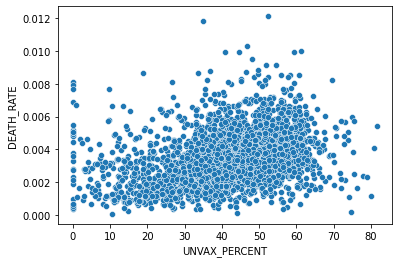

In [75]:
import seaborn as sns

sns.scatterplot(y=joined.DEATH_RATE, x=joined.UNVAX_PERCENT)

In [57]:
import numpy as np

In [76]:
joined.UNVAX_PERCENT.corr(joined.DEATH_RATE)

0.3358558327953451

In [77]:
## there are about a million people in counties reporting 0 fatalities 
# (which must be a reporting error)

joined[joined.DEATH_RATE == 0].sort_values('POPN', ascending=False)

,Admin2,Province_State,DEATHS,POPN,UNVAX_PERCENT,DEATH_RATE
FIPS,,,,,,


In [89]:
## OK, now let's pull in county level GDP and see how the correlation goes

"""
gdp_table <- read_html("https://en.wikipedia.org/wiki/List_of_United_States_counties_by_per_capita_income") %>%
        html_element(xpath = "//table[3]") %>%
        html_table() 
        #%>%
        #mutate(CountyState = paste("County or county-equivalent", ", ", "State, federal district or territory"))

colnames(gdp_table) <- c("Rank", "County", "State",
        "PerCapita", "MedianHousehold", "MedianFamily", "Population", "NumHouseholds")
"""

#per_capita = "https://en.wikipedia.org/wiki/List_of_United_States_counties_by_per_capita_income"

per_capita = "percapita.html" # TODO: remove cache

conversions = {
                'Population': int,
                'Number ofhouseholds': int
                }

html_crud = pd.read_html(per_capita)[2]

# this will make rows with "-" in them be nan
html_crud['Rank'] = pd.to_numeric(html_crud['Rank'], errors="coerce")

html_crud = html_crud.dropna()

## deal with dollar signs, y'all
# taken from: https://stackoverflow.com/questions/32464280/converting-currency-with-to-numbers-in-python-pandas

dollar_values = ['Per capitaincome', 'Medianhouseholdincome', 'Medianfamilyincome']


for v in dollar_values:
    html_crud[v] = html_crud[v].str.replace("[$,]", "", regex=True).astype(int)

html_crud = html_crud.dropna()

html_crud = html_crud.rename(columns = {
                                'County or county-equivalent': 'COUNTY',
                                'Per capitaincome': 'PER_CAPITA', 
                                'Medianhouseholdincome': 'MEDIAN_HOUSEHOLD',  
                                'Medianfamilyincome': 'MEDIAN_FAMILY',
                                'State, federal district or territory': 'STATE',
                                'Population': 'POPULATION',
                                'Number ofhouseholds': 'HOUSEHOLDS'}).astype({'POPULATION': int, 'HOUSEHOLDS': int})

html_crud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 0 to 3267
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              3143 non-null   float64
 1   COUNTY            3143 non-null   object 
 2   STATE             3143 non-null   object 
 3   PER_CAPITA        3143 non-null   int64  
 4   MEDIAN_HOUSEHOLD  3143 non-null   int64  
 5   MEDIAN_FAMILY     3143 non-null   int64  
 6   POPULATION        3143 non-null   int64  
 7   HOUSEHOLDS        3143 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 221.0+ KB


In [91]:
html_crud.STATE

0           New York
1           Virginia
2           Virginia
3         California
4         California
            ...     
3221           Texas
3222          Alaska
3232    South Dakota
3263         Georgia
3267    South Dakota
Name: STATE, Length: 3143, dtype: object

In [94]:
html_crud.COUNTY

0            New York County
1                  Arlington
2          Falls Church City
3                      Marin
4                Santa Clara
                ...         
3221                 Willacy
3222    Kusilvak Census Area
3232                    Todd
3263                 Wheeler
3267           Oglala Lakota
Name: COUNTY, Length: 3143, dtype: object

In [96]:
df2 = joined.merge(html_crud, on=['STATE', 'COUNTY'])

In [97]:
df2

,COUNTY,STATE,DEATHS,POPN,UNVAX_PERCENT,DEATH_RATE,Rank,PER_CAPITA,MEDIAN_HOUSEHOLD,MEDIAN_FAMILY,POPULATION,HOUSEHOLDS
0,Autauga,Alabama,194,55869.0,45.153842,0.003472,1142.0,24571,53682,66349,54907,20071
1,Baldwin,Alabama,640,223234.0,36.427695,0.002867,694.0,26766,50221,60864,187114,73283
2,Barbour,Alabama,93,24686.0,44.989063,0.003767,2947.0,16829,32911,43462,27321,9200
3,Bibb,Alabama,99,22394.0,57.778869,0.004421,2865.0,17427,36447,43004,22754,7091
4,Blount,Alabama,218,57826.0,62.065507,0.003770,2150.0,20730,44145,52996,57623,21108
...,...,...,...,...,...,...,...,...,...,...,...,...
2912,Sweetwater,Wyoming,123,42343.0,42.032922,0.002905,300.0,30517,71525,81595,44437,16682
2913,Teton,Wyoming,16,23464.0,0.000000,0.000682,29.0,43444,68078,83558,21575,7583
2914,Uinta,Wyoming,36,20226.0,41.031346,0.001780,942.0,25513,58515,73060,21040,7290
2915,Washakie,Wyoming,43,7805.0,53.440102,0.005509,459.0,28308,47104,64608,8468,3468


/Users/caseydurfee/.virtualenvs/py3-data/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PER_CAPITA', ylabel='DEATH_RATE'>

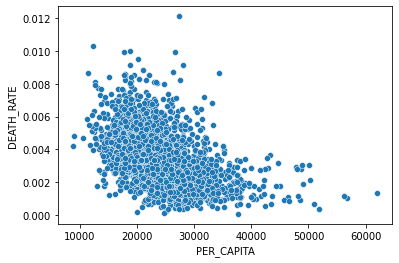

In [98]:
sns.scatterplot(x=df2.PER_CAPITA, y=df2.DEATH_RATE)